In [13]:
import pandas as pd
from plotly import __version__
from plotly import graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot
from matplotlib import pyplot as plt
import numpy as np


print(__version__)  # need 1.9.0 or greater

init_notebook_mode(connected=True)


def plotly_df(df, title=""):
    data = []

    for column in df.columns:
        trace = go.Scatter(x=df.index, y=df[column], mode="lines", name=column)
        data.append(trace)

    layout = dict(title=title)
    fig = dict(data=data, layout=layout)
    iplot(fig, show_link=False)

6.5.0


## Подготавливаем данные

Для начала скачаем данные в `dataframe`. Сегодня будем предсказывать просмотры wiki-страницы [Machine Learning](https://en.wikipedia.org/wiki/Machine_learning). Данные я скачала с помощью библиотеки [Wikipediatrend](https://www.r-bloggers.com/using-wikipediatrend/) для `R`.

In [14]:
df = pd.read_csv("wiki_machine_learning.csv", sep=" ")
df = df[df["count"] != 0]
df.head()

,date,count,lang,page,rank,month,title
81,2015-01-01,1414,en,Machine_learning,8708,201501,Machine_learning
80,2015-01-02,1920,en,Machine_learning,8708,201501,Machine_learning
79,2015-01-03,1338,en,Machine_learning,8708,201501,Machine_learning
78,2015-01-04,1404,en,Machine_learning,8708,201501,Machine_learning
77,2015-01-05,2264,en,Machine_learning,8708,201501,Machine_learning


In [15]:
df.shape

(383, 7)

In [16]:
df.date = pd.to_datetime(df.date)

In [17]:
plotly_df(df.set_index("date")[["count"]])

## Предсказание с помощью Facebook Prophet

Для начала построим предсказание с помощью простой библиотеки `Facebook Prophet`. Для того, чтобы посмотреть на качество модели, отбросим из обучающей выборки последние 30 дней.

In [18]:
from prophet import Prophet

In [19]:
predictions = 30

df = df[["date", "count"]]
df.columns = ["ds", "y"]
train_df = df[:-predictions].copy()

In [20]:
# Создаем и обучаем модель Prophet
model = Prophet()
model.fit(train_df)

14:06:49 - cmdstanpy - INFO - Chain [1] start processing
14:06:49 - cmdstanpy - INFO - Chain [1] done processing


**Вопрос 1:** Какое предсказание числа просмотров wiki-страницы на 20 января? Ответ округлите до целого числа.

Оценим качество предсказания по последним 30 точкам.

Прогноз на 20 января: 3422
MAPE: 34.35%
MAE: 596.70


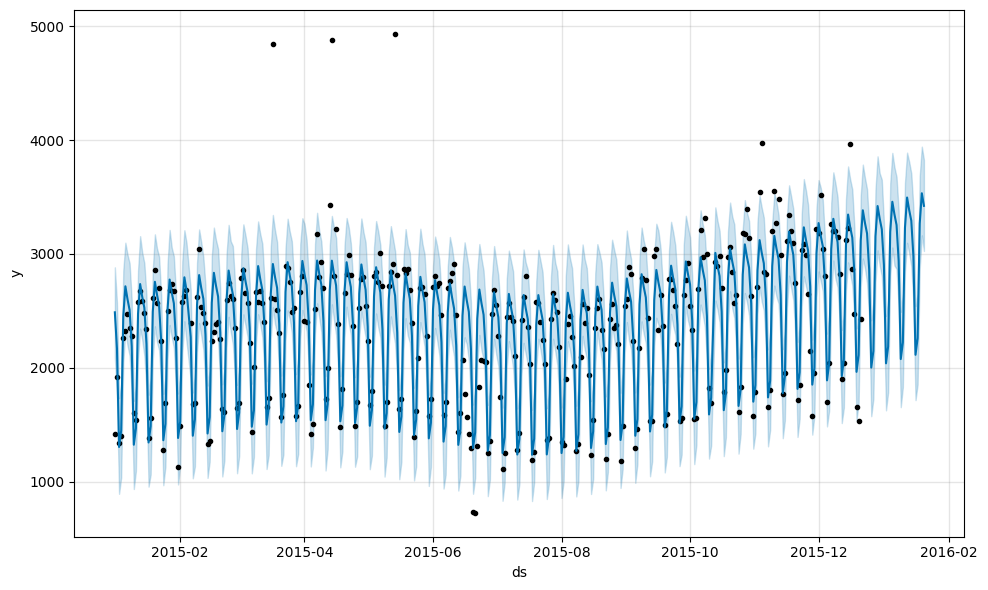

In [ ]:
future = model.make_future_dataframe(periods=predictions)
forecast = model.predict(future)

model.plot(forecast)

jan_20_forecast = forecast[forecast['ds'] == '2016-01-20']['yhat'].values[0]
print(f"Прогноз на 20 января: {round(jan_20_forecast)}")

test_df = df[-predictions:].copy()
forecast_test = forecast[-predictions:]

mape = np.mean(np.abs((test_df['y'].values - forecast_test['yhat'].values) / test_df['y'].values)) * 100
print(f"MAPE: {mape:.2f}%")

mae = np.mean(np.abs(test_df['y'].values - forecast_test['yhat'].values))
print(f"MAE: {mae:.2f}")

**Вопрос 2**: Какое получилось MAPE?

**Вопрос 3**: Какое получилось MAE?

## Предсказываем с помощью ARIMA

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats

**Вопрос 4:** Проверим стационарность ряда с помощью критерия Дики-Фулера. Является ли ряд стационарным? Какое значение p-value?

In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['y'])

print('p-value:', result[1])

p-value: 0.015383668419469067


**Вопрос 5**: Далее перейдем к построению модели SARIMAX (`sm.tsa.statespace.SARIMAX`). Модель c какими параметрами лучшая по `AIC`-критерию?

In [ ]:
import itertools
import warnings
warnings.filterwarnings("ignore")


p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in pdq]

print('Поиск лучших параметров...')

best_aic = 10**10
best_params = None
best_seasonal_params = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_df['y'],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit(disp=False)

            if results.aic < best_aic:
                best_aic = results.aic
                best_params = param
                best_seasonal_params = param_seasonal

            print(f'SARIMAX{param}x{param_seasonal} - AIC:{results.aic:.2f}')
        except:
            continue

print(f'\nЛучшая модель: SARIMAX{best_params}x{best_seasonal_params} AIC: {best_aic:.2f}')

best_model = sm.tsa.statespace.SARIMAX(train_df['y'],
                                       order=best_params,
                                       seasonal_order=best_seasonal_params,
                                       enforce_stationarity=False,
                                       enforce_invertibility=False)

best_results = best_model.fit(disp=False)

forecast_sarima = best_results.forecast(steps=predictions)

test_values = df[-predictions:]['y'].values
mape_sarima = np.mean(np.abs((test_values - forecast_sarima.values) / test_values)) * 100
mae_sarima = np.mean(np.abs(test_values - forecast_sarima.values))

print(f'\nSARIMAX MAPE: {mape_sarima:.2f}%')
print(f'SARIMAX MAE: {mae_sarima:.2f}')

Поиск лучших параметров...
SARIMAX(0, 0, 0)x(0, 0, 0, 7) - AIC:6488.10
SARIMAX(0, 0, 0)x(0, 0, 1, 7) - AIC:5992.99
SARIMAX(0, 0, 0)x(0, 0, 2, 7) - AIC:5622.20
SARIMAX(0, 0, 0)x(0, 1, 0, 7) - AIC:5174.35
SARIMAX(0, 0, 0)x(0, 1, 1, 7) - AIC:4982.96
SARIMAX(0, 0, 0)x(0, 1, 2, 7) - AIC:4886.27
SARIMAX(0, 0, 0)x(0, 2, 0, 7) - AIC:5414.17
SARIMAX(0, 0, 0)x(0, 2, 1, 7) - AIC:5005.72
SARIMAX(0, 0, 0)x(0, 2, 2, 7) - AIC:4814.41
SARIMAX(0, 0, 0)x(1, 0, 0, 7) - AIC:5193.84
SARIMAX(0, 0, 0)x(1, 0, 1, 7) - AIC:5088.31
SARIMAX(0, 0, 0)x(1, 0, 2, 7) - AIC:4988.79
SARIMAX(0, 0, 0)x(1, 1, 0, 7) - AIC:5038.47
SARIMAX(0, 0, 0)x(1, 1, 1, 7) - AIC:4984.40
SARIMAX(0, 0, 0)x(1, 1, 2, 7) - AIC:4887.38
SARIMAX(0, 0, 0)x(1, 2, 0, 7) - AIC:5182.13
SARIMAX(0, 0, 0)x(1, 2, 1, 7) - AIC:4961.87
SARIMAX(0, 0, 0)x(1, 2, 2, 7) - AIC:4815.83
SARIMAX(0, 0, 0)x(2, 0, 0, 7) - AIC:5040.31
SARIMAX(0, 0, 0)x(2, 0, 1, 7) - AIC:5000.89
SARIMAX(0, 0, 0)x(2, 0, 2, 7) - AIC:4987.76
SARIMAX(0, 0, 0)x(2, 1, 0, 7) - AIC:4908.88
SARIM